In [1]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'random'
data_setting = 'stft'
model_setting = 'DenseNet121'

d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

# X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 0.64 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 1.38 seconds.
Species: Ae. albopictus.
Read 20231 filenames in 1.38 seconds.
Species: An. arabiensis.
Read 19297 filenames in 1.38 seconds.
Species: An. gambiae.
Read 49471 filenames in 1.40 seconds.
Species: C. pipiens.
Read 30415 filenames in 1.39 seconds.
Species: C. quinquefasciatus.
Read 74599 filenames in 1.39 seconds.


{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

## Choosing model (6 classes or 3-merged)

In [2]:
merged = False

using_conv2d = False
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

    # Defining model parameters
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
    d.target_classes = ['Aedes','Anopheles','Culex']
    traincf.target_names = np.unique(d.target_classes)
    traincf.targets = len(traincf.target_names)    
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
    traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
    model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

############ INPUT SHAPE:(129, 120, 1)


In [3]:
d.target_classes

['Ae. aegypti',
 'Ae. albopictus',
 'An. arabiensis',
 'An. gambiae',
 'C. pipiens',
 'C. quinquefasciatus']

In [4]:
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 129, 120, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 135, 126, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 65, 60, 64)   3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 65, 60, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [5]:
# sig = next(valid_generator(X_val, y_val,
#                 batch_size=traincf.batch_size,
#                 target_names=traincf.target_names,
#                 setting=traincf.setting,
#                 preprocessing_train_stats='',
#                 using_conv2d=using_conv2d))[0][0,:,:]
# plt.plot(sig)

In [6]:
pd.Series(y_val).value_counts()

0    14798
5    12904
3     8557
4     5261
1     3499
2     3338
dtype: int64

### Model training

In [7]:
h = model.fit_generator(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=traincf.target_names,
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=traincf.target_names,
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6045 steps, validate for 1181 steps
Epoch 1/100
6044/6045 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8519
Epoch 00001: val_loss improved from inf to 2.09094, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_random_stft_DenseNet121_weights.h5
6045/6045 [==============================] - 582s 96ms/step - loss: 0.4039 - accuracy: 0.8519 - val_loss: 2.0909 - val_accuracy: 0.5452
Epoch 2/100
6044/6045 [============================>.] - ETA: 0s - loss: 0.2494 - accuracy: 0.9090
Epoch 00002: val_loss improved from 2.09094 to 1.29220, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_random_stft_DenseNet121_weights.h5
6045/6045 [==============================] - 571s 94ms/step - loss: 0.2494 - accuracy: 0.9090 - val_loss: 1.2922 - val_accuracy: 0.6456
Epoch 3/100
6044/6045 [=======

In [8]:
# model.load_weights('../temp_data/custom_raw_conv1d_0.h5')

In [9]:
features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=traincf.target_names,
                                                  preprocessing_train_stats=''),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

Instructions for updating:
Please use Model.predict, which supports generators.


In [10]:
features.shape

(37781, 6)

### Confusion matrix (test set)

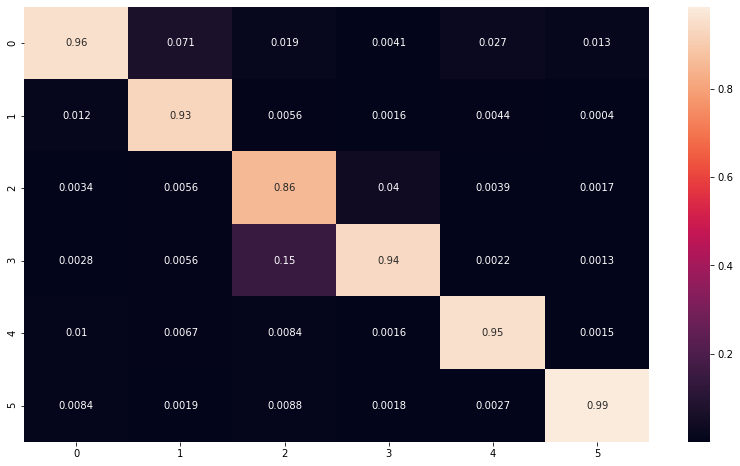

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(14,8))
cm = confusion_matrix(np.argmax(features, axis=1), y_test)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)
sb.heatmap(cm, annot=True)#, fmt='g')

In [13]:
pd.Series(y_test).value_counts()

2    35109
1     6831
0     5355
dtype: int64

In [14]:
pd.Series(np.argmax(features, axis=1)).value_counts()

2    34465
1     6525
0     6305
dtype: int64